In [1]:
!nvidia-smi

Sat Nov 19 17:47:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    12W /  N/A |    154MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
device = 'cuda:0'

# Read video frames:

In [3]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

In [4]:
ref_video_path = Path('data/ref_video.mp4')
save_frames_path = Path('data/frames')
save_frames_path.mkdir(exist_ok=True, parents=True)

In [5]:
def read_video(file, n_frames=None):
    capture = cv2.VideoCapture(file)
    fps = capture.get(cv2.CAP_PROP_FPS)
    if n_frames is None:
        n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

    frames = []

    for _ in tqdm(np.arange(n_frames)):
        success, image_cv = capture.read()

        if not success:
            break

        frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame/255, dtype=torch.float32)
        frames.append(frame.permute(2,0,1)[None])

    return frames, fps, n_frames

In [6]:
frames, fps, n_frames = read_video(str(ref_video_path), 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.80it/s]


# Preprocess data

In [7]:
import torchvision.transforms as T

In [8]:
def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

In [9]:
scale_factor = 0.5

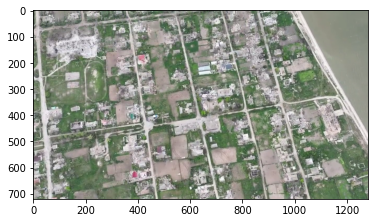

In [85]:
plt.imshow(frames[600:][0][0].permute(1,2,0))

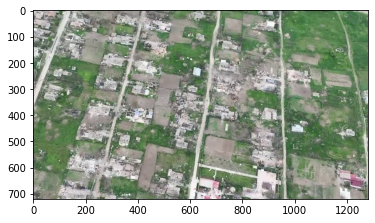

In [87]:
plt.imshow(frames[900:][0][0].permute(1,2,0))

In [88]:
timgs = []
frames2stitch_freq = 30
for i, frame in enumerate(frames[600:]):
    if i % frames2stitch_freq == 0:
        timgs.append(torch_resize(frame, scale_factor).to(device))

In [89]:
len(timgs), timgs[0].shape

(14, torch.Size([1, 3, 360, 640]))

# Stitch by kornia stitcher

In [90]:
# from kornia.contrib import ImageStitcher
# import kornia.feature as KF
# import kornia as K

# IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac').to(device)

In [91]:
# out = timgs[0]
# idxs = list(range(1, len(timgs)))
# for i in tqdm(idxs):
#     try:
#         prev_out = out
#         out = IS(*[out, timgs[i]])
#     except Exception as e:
#         print(e)
#         out = prev_out

In [92]:
# import matplotlib.pyplot as plt

In [93]:
# plt.figure(figsize=(16,16))
# plt.imshow(out[0].permute(1, 2, 0).cpu())

# Custom stitching

In [94]:
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn

import kornia.feature
from kornia.color import rgb_to_grayscale
from kornia.feature import LocalFeatureMatcher, LoFTR, BlobDoG, ScaleSpaceDetector
from kornia.geometry.homography import find_homography_dlt_iterated
from kornia.geometry.ransac import RANSAC
from kornia.geometry.transform import warp_perspective

import kornia.feature as KF
import matplotlib.pyplot as plt

In [95]:
#Now lets try with Difference-of-Gaussians + OriNet + TFeat
class CustMatcher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.PS = 41

        sift = kornia.feature.TFeat(True).to(device)
        sift = kornia.feature.SIFTDescriptor(self.PS, rootsift=True).to(device)

        self.descriptor = sift

        resp = BlobDoG()
        scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, self.PS, double_image=True)

        nms = kornia.geometry.ConvQuadInterp3d(10)

        n_features = 4000
        self.detector = ScaleSpaceDetector(n_features,
                                      resp_module=resp,
                                      scale_space_response=True,#We need that, because DoG operates on scale-space
                                      nms_module=nms,
                                      scale_pyr_module=scale_pyr,
                                      ori_module=kornia.feature.LAFOrienter(32, 
                                                                            angle_detector=kornia.feature.OriNet(True)),
                                      mr_size=6.0,
                                      minima_are_also_good=True).to(device) #dark blobs are as good as bright.

    def get_descriptors(self, img):
        """
        img shape: B, C, H, W
        """
        with torch.no_grad():
            lafs, resps = self.detector(img)
            patches =  kornia.feature.extract_patches_from_pyramid(img, lafs, self.PS)
            B, N, CH, H, W = patches.size()
            # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
            # So we need to reshape a bit :) 
            descs = self.descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs
        
    def forward(self, image_pair):
        """
        image_pair: dict = {
            "image0": img,
            "image1": img
        }
        """
        with torch.no_grad():
            lafs_src, descs_src = self.get_descriptors(image_pair['image0'])
            lafs_dst, descs_dst = self.get_descriptors(image_pair['image1'])
            scores, matches = kornia.feature.match_snn(descs_src[0], descs_dst[0], 0.9)

        src_pts = lafs_src[0,matches[:,0], :, 2]
        dst_pts = lafs_dst[0,matches[:,1], :, 2]
        
        return (src_pts, dst_pts, matches)

In [96]:
matcher = CustMatcher().to(device)
estimator = 'ransac'
blending_method = 'naive'
ransac = RANSAC('homography').to(device)

In [97]:
matcher.detector?

Signature:      matcher.detector(*input, **kwargs)
Type:           ScaleSpaceDetector
String form:   
ScaleSpaceDetector(num_features=4000, mr_size=6.0, scale_pyr=ScalePyramid(n_levels=3, init_sigma= <...> adding=(1, 1))
           (20): Tanh()
           (21): AdaptiveAvgPool2d(output_size=1)
           )
           )), aff=PassLAF())
File:           /opt/conda/lib/python3.8/site-packages/kornia/feature/scale_space_detector.py
Docstring:     
Module for differentiable local feature detection, as close as possible to classical local feature detectors
like Harris, Hessian-Affine or SIFT (DoG).

It has 5 modules inside: scale pyramid generator, response ("cornerness") function,
soft nms function, affine shape estimator and patch orientation estimator.
Each of those modules could be replaced with learned custom one, as long, as
they respect output shape.

Args:
    num_features: Number of features to detect. In order to keep everything batchable,
      output would always have num_feature

In [98]:
global_inliers = []

def estimate_homography(keypoints1: torch.Tensor, keypoints2: torch.Tensor) -> torch.Tensor:
    """Estimate homography by the matched keypoints.

    Args:
        keypoints1: matched keypoint set from an image, shaped as :math:`(N, 2)`.
        keypoints2: matched keypoint set from the other image, shaped as :math:`(N, 2)`.
    """
    homo, mask = ransac(keypoints2, keypoints1)
    homo = homo[None]
    return homo, mask

def estimate_transform(src_pts, dst_pts, matches) -> torch.Tensor:
    """Compute the corresponding homography."""
    kp1, kp2, idx = src_pts, dst_pts, matches
    homo, mask = estimate_homography(kp1, kp2)
    # print("matches.shape", matches.shape)
    # print("mask.shape", mask.shape)
    # print("homo.shape", homo.shape)
    inliers = matches[mask.bool().squeeze(), :]
    print(len(inliers))
    global_inliers.append(len(inliers))
    if len(homo) == 0:
        raise RuntimeError("Compute homography failed. No matched keypoints found.")
    return homo, len(inliers)

def blend_image(src_img: torch.Tensor, dst_img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Blend two images together."""
    out: torch.Tensor
    out = torch.where(mask == 1, src_img, dst_img)
    return out

def preprocess(image_1: torch.Tensor, image_2: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Preprocess input to the required format."""
    input_dict: Dict[str, torch.Tensor] = {
            "image0": rgb_to_grayscale(image_1),
            "image1": rgb_to_grayscale(image_2),
        }
    return input_dict

def postprocess(image: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # NOTE: assumes no batch mode. This method keeps all valid regions after stitching.
    mask_: torch.Tensor = mask.sum((0, 1))
    index: int = int(mask_.bool().any(0).long().argmin().item())
    if index == 0:  # If no redundant space
        return image
    return image[..., :index]

def on_matcher(data):
    return matcher(data)

def stitch_pair(
    images_left: torch.Tensor,
    images_right: torch.Tensor,
    mask_left: Optional[torch.Tensor] = None,
    mask_right: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Compute the transformed images
    input_dict: Dict[str, torch.Tensor] = preprocess(images_left, images_right)
    out_shape: Tuple[int, int] = (images_left.shape[-2], images_left.shape[-1] + images_right.shape[-1])
    print("out_shape", out_shape)
    src_pts, dst_pts, matches = on_matcher(input_dict)
    homo, n_inliers = estimate_transform(src_pts, dst_pts, matches)
    if n_inliers < 200:
        return images_left, mask_left
        
    src_img = warp_perspective(images_right, homo, out_shape)
    print("src_img.shape", src_img.shape)
    dst_img = torch.cat([images_left, torch.zeros_like(images_right)], dim=-1)

    # Compute the transformed masks
    if mask_left is None:
        mask_left = torch.ones_like(images_left)
    if mask_right is None:
        mask_right = torch.ones_like(images_right)
    # 'nearest' to ensure no floating points in the mask
    src_mask = warp_perspective(mask_right, homo, out_shape, mode='nearest')
    print("src_mask.shape", src_mask.shape)
    dst_mask = torch.cat([mask_left, torch.zeros_like(mask_right)], dim=-1)
    blended_img, blended_mask = blend_image(src_img, dst_img, src_mask), (dst_mask + src_mask).bool().to(src_mask.dtype)
    print("blended_img.shape", blended_img.shape)
    return blended_img, blended_mask

In [99]:
global_inliers

[]

In [100]:
img_out.shape, timgs[i + 1].shape

IndexError: list index out of range

In [101]:
with torch.inference_mode():
    img_out = timgs[0]
    mask_left = torch.ones_like(img_out).to(device)
    for i in tqdm(list(range(len(timgs) - 1))):
        _img_out, _mask_left = stitch_pair(img_out, timgs[i + 1], mask_left)
        img_out = postprocess(_img_out, _mask_left)    
        # break

  0%|                                                                                            | 0/13 [00:00<?, ?it/s]

out_shape (360, 1280)


  8%|██████▍                                                                             | 1/13 [00:01<00:12,  1.03s/it]

1799
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 15%|████████████▉                                                                       | 2/13 [00:01<00:09,  1.16it/s]

852
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 23%|███████████████████▍                                                                | 3/13 [00:02<00:07,  1.28it/s]

601
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 31%|█████████████████████████▊                                                          | 4/13 [00:03<00:06,  1.36it/s]

575
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 38%|████████████████████████████████▎                                                   | 5/13 [00:03<00:05,  1.43it/s]

563
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 46%|██████████████████████████████████████▊                                             | 6/13 [00:04<00:04,  1.41it/s]

369
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 54%|█████████████████████████████████████████████▏                                      | 7/13 [00:05<00:04,  1.38it/s]

220
src_img.shape torch.Size([1, 3, 360, 1280])
src_mask.shape torch.Size([1, 3, 360, 1280])
blended_img.shape torch.Size([1, 3, 360, 1280])
out_shape (360, 1280)


 62%|███████████████████████████████████████████████████▋                                | 8/13 [00:05<00:03,  1.40it/s]

140
out_shape (360, 1280)


 69%|██████████████████████████████████████████████████████████▏                         | 9/13 [00:06<00:02,  1.38it/s]

6
out_shape (360, 1280)


 77%|███████████████████████████████████████████████████████████████▊                   | 10/13 [00:07<00:02,  1.38it/s]

6
out_shape (360, 1280)


 85%|██████████████████████████████████████████████████████████████████████▏            | 11/13 [00:08<00:01,  1.39it/s]

5
out_shape (360, 1280)


 92%|████████████████████████████████████████████████████████████████████████████▌      | 12/13 [00:08<00:00,  1.40it/s]

5
out_shape (360, 1280)


100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]

5


In [58]:
_img_out.shape

torch.Size([1, 3, 360, 1280])

In [59]:
_mask_left.shape

torch.Size([1, 3, 360, 1280])

In [60]:
img_out.shape

torch.Size([1, 3, 360, 1280])

In [61]:
img_out.shape

torch.Size([1, 3, 360, 1280])

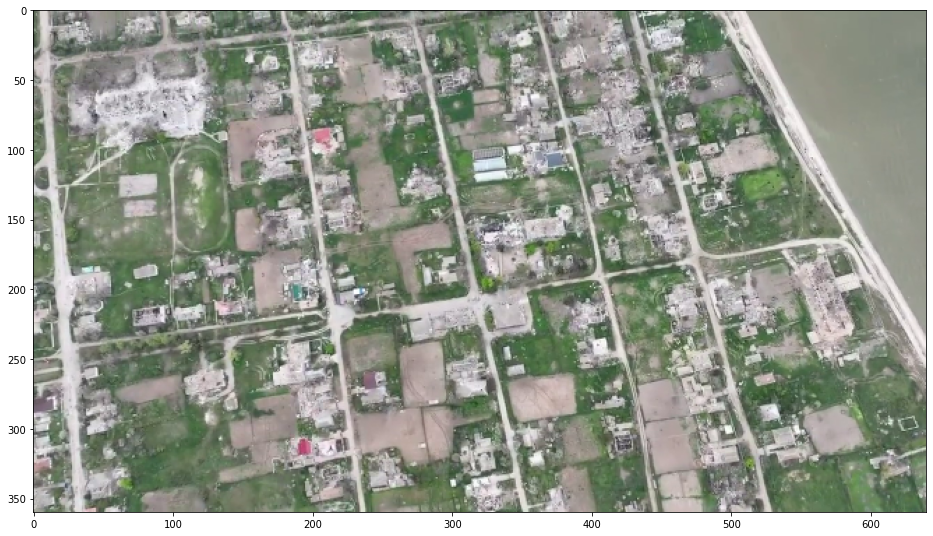

In [102]:
plt.figure(figsize=(16,16))
plt.imshow(timgs[0][0].permute(1, 2, 0).cpu())

In [103]:
plt.figure(figsize=(16,16))
plt.imshow(timgs[20][0].permute(1, 2, 0).cpu())

IndexError: list index out of range

<Figure size 1152x1152 with 0 Axes>

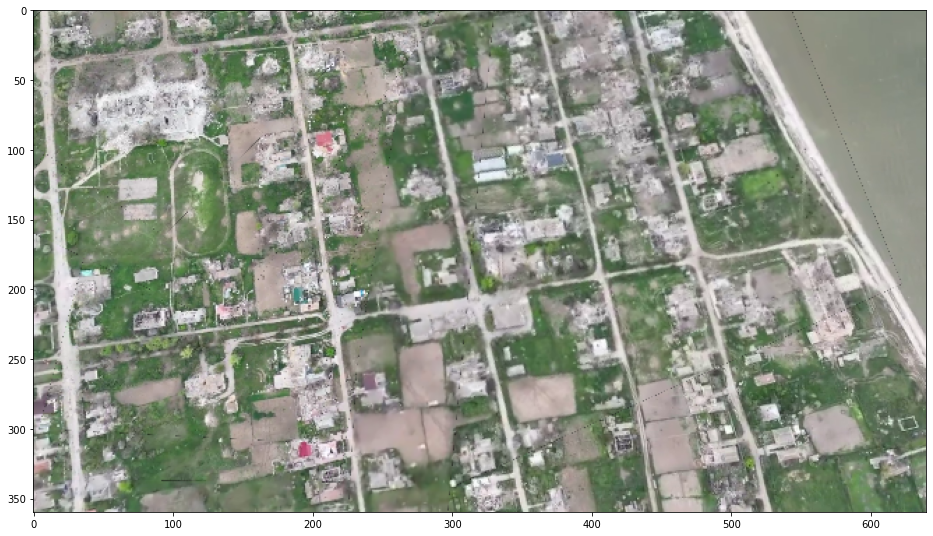

In [104]:
plt.figure(figsize=(16,16))
plt.imshow(_img_out[0].permute(1, 2, 0).cpu())